In [217]:
import pandas as pd
import numpy as np

from sklearn.metrics.pairwise import pairwise_distances

#For plotting
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt
from pandas.plotting import scatter_matrix

from itertools import chain

In [218]:
# Get time series data:
data = pd.read_csv('GamesDataAll.csv')

# Make percentile into number and clear "-"
data = data.replace(to_replace='%', value='', regex=True).replace({'-':'NaN'})#.replace(to_replace='Inf', value=+100, regex=True)
#data['Perc_Gain'] = data['Perc_Gain']/100

data.head()

,App_id,Name,Avg_Players,Gain,Perc_Gain,Peak_Players,Last 30 Days,April 2021,March 2021,February 2021,...,April 2013,March 2013,February 2013,January 2013,December 2012,November 2012,October 2012,September 2012,August 2012,July 2012
0,730,Counter-Strike: Global Offensive,1,0,0,0,695044.47,723346.52,740927.82,741013.24,...,16006.0,15959.89,17372.73,16164.22,14079.39,14134.1,10739.48,16000.75,15475.39,932.57
1,730,Counter-Strike: Global Offensive,0,1,0,0,-28302.0,-17581.31,-85.42,-2196.42,...,46.11,-1412.84,1208.51,2084.83,-54.71,3394.62,-5261.27,525.36,14542.81,NaN
2,730,Counter-Strike: Global Offensive,0,0,1,0,-3.91,-2.37,-0.01,-0.30,...,+0.29,-8.13,+7.48,+14.81,-0.39,+31.61,-32.88,+3.39,+1559.43,NaN
3,730,Counter-Strike: Global Offensive,0,0,0,1,1119102,1148077,1198581,1123485,...,31966,32166,35238,31359,27553,50533,20850,36057,52261,1642
4,570,Dota 2,1,0,0,0,413025.27,413784.97,390412.76,404832.13,...,174835.73,180878.9,166972.97,147748.14,121924.42,101077.43,75965.44,61867.68,55768.61,52721.05


In [219]:
# Get Perc_Gain.
p_gain = data.loc[data['Perc_Gain']==1]
p_gain = p_gain.drop(columns=['Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players','Last 30 Days'])
p_gain_pure = p_gain.drop(columns=['App_id', 'Name']).astype(float)

# Get Avg_Players.
avg_players = data.loc[data['Avg_Players']==1]
avg_players = avg_players.drop(columns=['Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players','Last 30 Days'])
avg_pure = avg_players.drop(columns=['App_id', 'Name']).astype(float)

In [220]:
# Add columns of max and mean
avg_players['max'] = avg_pure.max(axis=1)
avg_players['mean'] = avg_pure.mean(axis=1)

In [221]:
features = pd.read_csv('games-features.csv')
features = features.drop_duplicates(subset=['ResponseID','ResponseName'], keep='first', inplace=False, ignore_index=False)
features = features.drop(columns=['QueryID', 'QueryName','RequiredAge'])
features = features.rename(columns={'ResponseID':'App_id','ResponseName':'Name'}, errors="raise")

data_craig = pd.merge(features, avg_players[['App_id','max','mean']], how='inner', on=['App_id'])
data_craig = data_craig.loc[data_craig['GenreIsNonGame']==False]
data_craig.sort_values(by=['max'], ascending=False, inplace=True)#.reset_index(drop=True)"

#grades = [1]*50+[2]*50+[3]*400+[4]*500+[5]*2450
#avg_graded = avg_players.loc[avg_players['max']>=1].copy()
#data_craig['Grade'] = grades

data_craig.reset_index(drop=True).to_csv('CraigGamesData.csv')

In [222]:
data_craig.sample(5)

,App_id,Name,ReleaseDate,DemoCount,DeveloperCount,DLCCount,Metacritic,MovieCount,PackageCount,RecommendationCount,...,SupportedLanguages,Website,PCMinReqsText,PCRecReqsText,LinuxMinReqsText,LinuxRecReqsText,MacMinReqsText,MacRecReqsText,max,mean
1306,253940,Septerra Core,Sep 27 2013,0,0,0,72,1,1,342,...,English* German**languages with full audio sup...,http://www.septerra.de,Minimum:OS: Windows 98 / XP / Vista / 7 / 8Pro...,Recommended:OS: Windows 98 / XP / Vista / 7 / ...,,,Minimum:OS: Snow LeopardProcessor: Intel Mac 2...,Recommended:OS: Snow LeopardProcessor: Multico...,210.34,34.610652
3060,456540,STAR WARS(tm): Rebel Assault I + II,Mar 29 2016,0,1,0,0,2,2,0,...,English**languages with full audio support,None,Minimum:OS: Windows 7/8/10Processor: 1.8 GHz P...,,,,,,2.59,0.686316
3233,496030,Dark Parables: The Swan Princess and The Dire ...,Jul 6 2016,0,1,0,0,1,1,0,...,English**languages with full audio support,None,Minimum:OS: Windows XP/Windows Vista/Windows 7...,,,,,,1.43,0.644561
3063,456980,Parallels Cross,Mar 30 2016,0,2,0,0,1,1,0,...,English,None,Minimum:OS: Windows 7Processor: 1.6 GHzMemory:...,,Minimum:OS: Ubuntu 13+Processor: 1.6 GHzMemory...,,Minimum:OS: 10.11Processor: 1.6 GHzMemory: 102...,,239.96,16.804773
205,9880,Champions Online,Jun 14 2011,0,1,0,72,0,0,2160,...,English,http://www.arcgames.com/en/games/champions-online,Minimum:OS: Windows XP/Vista/Windows 7Processo...,Recommended:OS: Windows XP/Vista/Windows 7Proc...,,,,,363.68,186.768113


In [223]:
#standard: a column name used to rank the games
#ranks: a list of rank cutoffs

def grade_analysis(ranks,standard='max', plot_cutoff=False,plot_figures=True,fig_size=(12,12)):
       
    grade = list(range(1,len(ranks)+1))
    a = np.array(ranks[1:]+[len(data_craig)] ) - np.array( [0] + ranks[1:])
    grades = []
    for i in range(len(grade)):
        grades.append( [grade[i]]*a[i] )    
    grades = list(chain(*grades))
    
    # Sort data according to the 'standard'
    data_craig_copy=data_craig.copy()
    data_craig_copy.sort_values(by=[standard], ascending=False, inplace=True)#.reset_index(drop=True)
    avg_graded = data_craig_copy#.loc[data_craig[standard]>=1].copy()

    # Rank the games
    if plot_cutoff:
        print('Using '+str(standard)+' :')
        for i in ranks:
            print('The cutoff for top '+str(i)+' games is '+str(avg_graded.reset_index(drop=True)[standard][i]))

    cutoffs = [0] + [avg_graded.reset_index(drop=True)[standard][i] for i in ranks[::-1]]
    #counts  = avg_graded[standard].value_counts(bins=cutoffs, sort=False,dropna=False) 
    #print(counts)

    #avg_graded = avg_players.loc[avg_players[standard]>=1].copy()
    avg_graded['Grade'] = grades

    data_clean = avg_graded[[#'ReleaseDate', 
        'CategorySinglePlayer',
       'CategoryMultiplayer', 
       'GenreIsIndie', 
                         'GenreIsAction', 
                         'GenreIsAdventure', 
                         'GenreIsCasual',
       'GenreIsStrategy', 
                         'GenreIsRPG', 
                         'GenreIsSimulation','Grade']]

#threshold = .2
#data_clean = data_clean.drop(data_clean.mean(axis=0)[data_clean.mean(axis=0) < threshold].index.values,axis=1)

    data_clean.columns = ['Single', 'Multi', 'Indie',
       'Action', 'Adventure', 'Casual', 'Strategy',
       'RPG', 'Simulation', 'Grade']

    data_test = {}
    for i in grade:
        data_test[i] = data_clean.loc[data_clean['Grade']==i].drop(columns=['Grade'])
        
    if plot_figures:
        plt.figure(figsize=fig_size)
        for i in grade:
            plt.plot(data_test[i].columns,data_test[i].mean(),label='Grade '+str(i))

        plt.legend()
        plt.title('By max of Avg_players')
        plt.show()
    return data_test

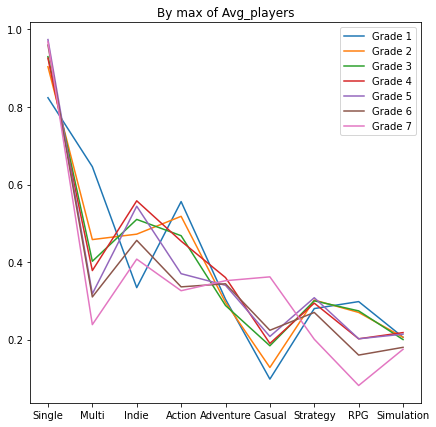

In [224]:
# We plot one figure given one ranking method here:
fig_size=(7,7)
ranks = list(np.arange(0,3500,500))
data_max = grade_analysis(ranks,standard='max', plot_cutoff=False,plot_figures=True,fig_size=fig_size)

In [225]:
# This function plots different methods together:
def grade_analysis_plot_all(methods,ranks,fig_size=(24,6)):
    fig,ax=plt.subplots(1,len(methods),figsize=fig_size)
    for j in range(len(methods)):
        data = grade_analysis(ranks,standard= methods[j], plot_figures=False).copy()
        for i in list(range(1,len(ranks)+1)):    
            ax[j].plot(data[i].columns,data[i].mean(),label='Grade '+str(i))
            ax[j].set_title('By '+str(methods[j]))
        ax[j].legend()
    plt.show()

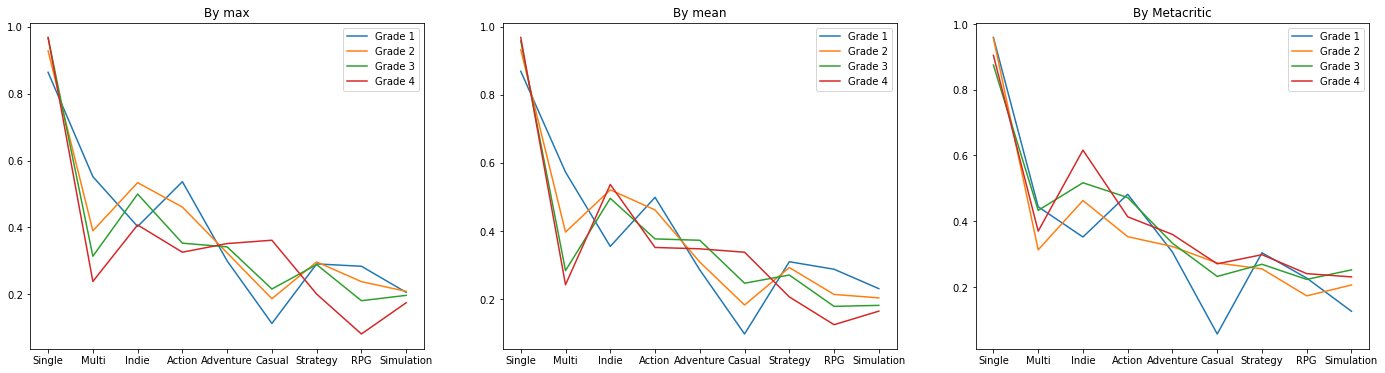

Rank cutoffs are [0, 1000, 2000, 3000]


In [226]:
methods = ['max','mean','Metacritic']
ranks = list(np.arange(0,3500,1000))
grade_analysis_plot_all(methods,ranks,fig_size=(24,6))
print('Rank cutoffs are '+str(ranks))

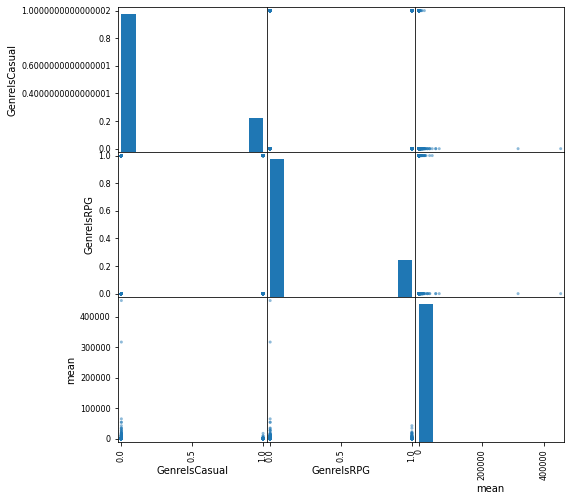

In [106]:
data_test = data_craig[[ #'RecommendationCount',
        #'CategorySinglePlayer',
       #'CategoryMultiplayer', 
#       'GenreIsIndie', 
#                       'GenreIsAction', 
#                        'GenreIsAdventure', 
                        'GenreIsCasual',
#       'GenreIsStrategy', 
                         'GenreIsRPG', 
#                        'GenreIsSimulation', 
       #'PriceFinal',
                        'mean']].astype(float)

scatter_matrix(data_test,figsize=(8,8))
plt.show()

In [109]:
data_craig.mean()

App_id                         284823.060234
DemoCount                           0.115901
DeveloperCount                      1.105909
DLCCount                            1.574650
Metacritic                         27.872110
MovieCount                          1.605481
PackageCount                        1.369112
RecommendationCount              3833.971453
PublisherCount                      1.069940
ScreenshotCount                    11.206109
SteamSpyOwners                 506934.369112
SteamSpyOwnersVariance          12065.960034
SteamSpyPlayersEstimate        347759.336283
SteamSpyPlayersVariance          9537.864402
AchievementCount                   22.966600
AchievementHighlightedCount         4.904082
ControllerSupport                   0.243506
IsFree                              0.097631
FreeVerAvail                        0.003426
PurchaseAvail                       0.839852
SubscriptionAvail                   0.001998
PlatformWindows                     1.000000
PlatformLi